# NQ-0 Filtering

in order to increase the efficiency of our system we need to filter nq-0 which might prevent a large number of our users from getting performant for a particular partner. this is a way of avoiding systemic blocks on users for various reasons. 


each partner has its own status codes and various mechanisms that would prevent a user from being able to take surveys with them. the goal of this is to find instances of users who underperform with 

In [ ]:
%load_ext autoreload
%autoreload 2

In [4]:
# import libs
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import pymoo

from utils import *

## Data Analysis 

goals:
- understand distribution of nq rates for users

In [ ]:
df = pd.read_csv('./data/partner_users_dataset.csv')

[]

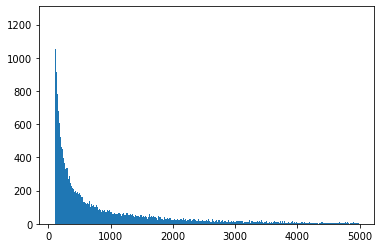

In [38]:
plt.hist(df['user_id'].value_counts().values, bins=[i*10 for i in range(10, 5*100)])
plt.plot()

In [ ]:
#df_users = df.groupby(['user_id'])
#100.*df_users.result.eq(3).sum()/df.shape[0]

df_users = df.groupby(['user_id', 'result'])#.agg({'sales': 'sum'})
df_result = df.groupby(['result'])#.agg({'sales': 'sum'})
df_users.div(df_result, level='result') * 100


#plt.hist(df[df['result'] == 3]['user_id'].value_counts().values, bins=[i*10 for i in range(10, 5*100)])
#plt.plot()

## Define Optimization Scheme

In [10]:
# import modules
from multiprocessing.pool import ThreadPool
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_sampling, get_crossover, get_mutation, get_reference_directions, get_termination
from pymoo.optimize import minimize
import numpy as np

# import utils
from utils import *

In [12]:
# define optimization function
def optimize_nq_filtering(user_pct=0.01, population_size=100, n_offsprings=20, term_gens=10, n_partitions=12, n_threads=5, random_seed=0, save=True, verbose=True):
    
    '''
    this function optimizes the nq filtering algorithm on a set of data
    goal is to find the optimal filtering parameters to be used
    '''
    
    
    print_msg('loading data')
    
    data = generate_data(path='./data/partner_users_dataset.csv', user_pct=user_pct)
    
    print_msg('data loaded')
    print_msg('estimating runtime')
    est_time = estimated_run_time(data, simulate_filtering, population_size=population_size, term_gens=term_gens, n_threads=n_threads)
    print_msg('estimated runtime: {} min'.format(est_time))
    
    print_msg('initializing objects')
    # start time of experiment 
    start_time = time.time()
    
    # initialize the pool
    pool = ThreadPool(n_threads)

    # define the problem by passing the starmap interface of the thread pool
    problem = FilteringNQs(
        runner=pool.starmap,
        func_eval=starmap_parallelized_eval,
        data=data
    )
    
    # create the reference directions to be used for the optimization
    ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=n_partitions)

    # optimization algorithm to use (may need to play around with this)
    algorithm = NSGA2(
        pop_size=population_size,
        n_offsprings=n_offsprings,
        sampling=get_sampling("real_random"),
        crossover=get_crossover("real_sbx", prob=0.9, eta=15),
        mutation=get_mutation("real_pm", eta=20),
        eliminate_duplicates=True,
        ref_dirs=ref_dirs
    )

    termination = get_termination("n_gen", term_gens)
    
    print_msg('starting optimization')
    res = minimize(problem,
                   algorithm,
                   termination,
                   seed=random_seed,
                   save_history=True,
                   verbose=True
                  )
    
    print_msg('finished optimization')
    
    X = res.X
    F = res.F
    
    if save:
        
        print_msg('saving results')
        params = {
            'percent_of_users_used': '{}%'.format(round(100*user_pct, 0)),
            'population_size': population_size,
            'number_of_offspring': n_offsprings,
            'term_on_generation_n': term_gens,
            'n_partitions': n_partitions,
            'number_of_threads': n_threads,
            'random_seed': random_seed,
            'time_taken_minutes': round((time.time() - start_time)/60, 2)
        }
        
        folder_name = time.strftime("%Y-%m-%d_%H:%M:%S", time.localtime())
        os.makedirs('./results/{}'.format(folder_name))
        
        save_optimization_results(F, X, params, folder_name=folder_name)
        
    print_msg('done')
            

In [13]:
optimize_nq_filtering(user_pct=0.01, population_size=100, n_offsprings=40, term_gens=20, n_partitions=12, n_threads=12, random_seed=0, save=True, verbose=True)

2021-11-16 08:26:52 | loading data
2021-11-16 08:27:08 | loaded 34,580,407 rows
2021-11-16 08:27:09 | 989 users selected
2021-11-16 08:27:12 | loaded 308,675 rows from selected users
2021-11-16 08:27:15 | converting to dictionary


100%|██████████| 956/956 [00:00<00:00, 2482.37it/s]


2021-11-16 08:27:15 | data loaded
2021-11-16 08:27:15 | estimating runtime


  0%|          | 0/956 [00:00<?, ?it/s]

2021-11-16 08:27:15 | unable to estimate runtime
2021-11-16 08:27:15 | estimated runtime: 1637080035.735581 min
2021-11-16 08:27:15 | initializing objects


NameError: name 'np' is not defined

In [2]:
data = generate_data(path='./data/partner_users_dataset.csv', user_pct=0.01)

(34580407, 8)
(34580407, 8)
(33165691, 8)


100%|██████████| 4434/4434 [00:00<00:00, 20706.18it/s]


In [ ]:
simulate_filtering(data, x=[26.437167465651434, 20.87477687489137, 13.9190669464003, 41.30969749020242, 14.885932066024598], verbose=True, filter_nqs=True)